In [88]:

import matplotlib.pyplot as plt
import os
import numpy as np

In [178]:
class RRBenchmark:
    def parse_file(self,quantum, run_count):
        benchmark_result = {}
        
        for rc in range(1,run_count+1):
            with open(f"rr_benchmark/quantum_{quantum}/run_{rc}.txt") as f:
                lines = list(f)
                benchmark_line = 0
                total_lines = len(lines)
                for i,l in enumerate(lines):
                    if "=Benchmark=" in l:
                        benchmark_line = i
                ##############################
                for ci in range(benchmark_line + 1, total_lines, 2):
                    command = lines[ci][:-1]
                    result = lines[ci+1]
                    if not command in benchmark_result.keys():
                        benchmark_result[command] = {"response_time": [], "burst_time": [], "turnaround_time": [], "waiting_time": []}
                    
                    components = list(map(lambda l: l.strip(), result.split(", ")))
                    for comp in components:
                        comp_split = list(map(lambda c: c.strip(), comp.split(":")))
                        benchmark_result[command][comp_split[0]].append(int(comp_split[1]))

        return benchmark_result

    def read_available_quantums(self,path):
        dir_names = list(map(lambda dir: dir.name ,list(os.scandir(path))))
        return sorted(list(map(lambda dir_name: int(dir_name.split("_")[1]) ,dir_names)))

    def load_benchmark(self, ignore_outliers = True, transformer = None):
        results = {}
        for quantum in self.read_available_quantums("rr_benchmark"):
            benchmark_result = self.parse_file(quantum, 10)
            for command in benchmark_result.keys():
                if not command in results:
                    results[command] = {"response_time": {}, "burst_time": {}, "turnaround_time": {}, "waiting_time": {}}
                
                for metric in ["response_time", "burst_time", "turnaround_time", "waiting_time"]:
                    results[command][metric][quantum] = np.array(benchmark_result[command][metric])
                    if ignore_outliers:
                        stats = results[command][metric][quantum]
                        stats_mean = stats.mean()
                        stats_std = stats.std()
                        filtered = stats[np.abs(stats - stats_mean) / stats_std < 3]
                        if transformer is not None:
                            results[command][metric][quantum] = transformer(filtered)
        return results

In [179]:
class FIFOBenchmark:
    def parse_file(self,run_count):
        benchmark_result = {}
        
        for rc in range(1,run_count+1):
            with open(f"fifo_benchmark/run_{rc}.txt") as f:
                lines = list(f)
                benchmark_line = 0
                total_lines = len(lines)
                for i,l in enumerate(lines):
                    if "=Benchmark=" in l:
                        benchmark_line = i
                ##############################
                for ci in range(benchmark_line + 1, total_lines, 2):
                    command = lines[ci][:-1]
                    result = lines[ci+1]
                    if not command in benchmark_result.keys():
                        benchmark_result[command] = {"response_time": [], "burst_time": [], "turnaround_time": [], "waiting_time": []}
                    
                    components = list(map(lambda l: l.strip(), result.split(", ")))
                    for comp in components:
                        comp_split = list(map(lambda c: c.strip(), comp.split(":")))
                        benchmark_result[command][comp_split[0]].append(int(comp_split[1]))

        return benchmark_result

    def read_available_quantums(self,path):
        dir_names = list(map(lambda dir: dir.name ,list(os.scandir(path))))
        return sorted(list(map(lambda dir_name: int(dir_name.split("_")[1]) ,dir_names)))

    def load_benchmark(self, ignore_outliers = True, transformer = None):
        results = {}
        benchmark_result = self.parse_file(10)
        for command in benchmark_result.keys():
            if not command in results:
                    results[command] = {"response_time": None, "burst_time": None, "turnaround_time": None, "waiting_time": None}
            for metric in ["response_time", "burst_time", "turnaround_time", "waiting_time"]:
                if ignore_outliers:
                    stats = np.array(benchmark_result[command][metric])
                    stats_mean = stats.mean()
                    stats_std = stats.std()
                    filtered = stats[np.abs(stats - stats_mean) / stats_std < 3]
                    if transformer is not None:
                        results[command][metric] = np.array(transformer(filtered))
                    else:
                        results[command][metric] = np.array(filtered)
                else:
                    results[command][metric] = np.array(benchmark_result[command][metric])
        return results

In [180]:
fifo_benchmark = FIFOBenchmark()
rr_benchmark = RRBenchmark()
rr_results = rr_benchmark.load_benchmark(ignore_outliers=True, transformer=None)
fifo_results = fifo_benchmark.load_benchmark(ignore_outliers=True,transformer=None)


In [182]:
rr_command1 = list(rr_results.keys())[0]
rr_command2 = list(rr_results.keys())[1]
rr_command3 = list(rr_results.keys())[2]

fifo_command1 = list(fifo_results.keys())[0]
fifo_command2 = list(fifo_results.keys())[1]
fifo_command3 = list(fifo_results.keys())[2]

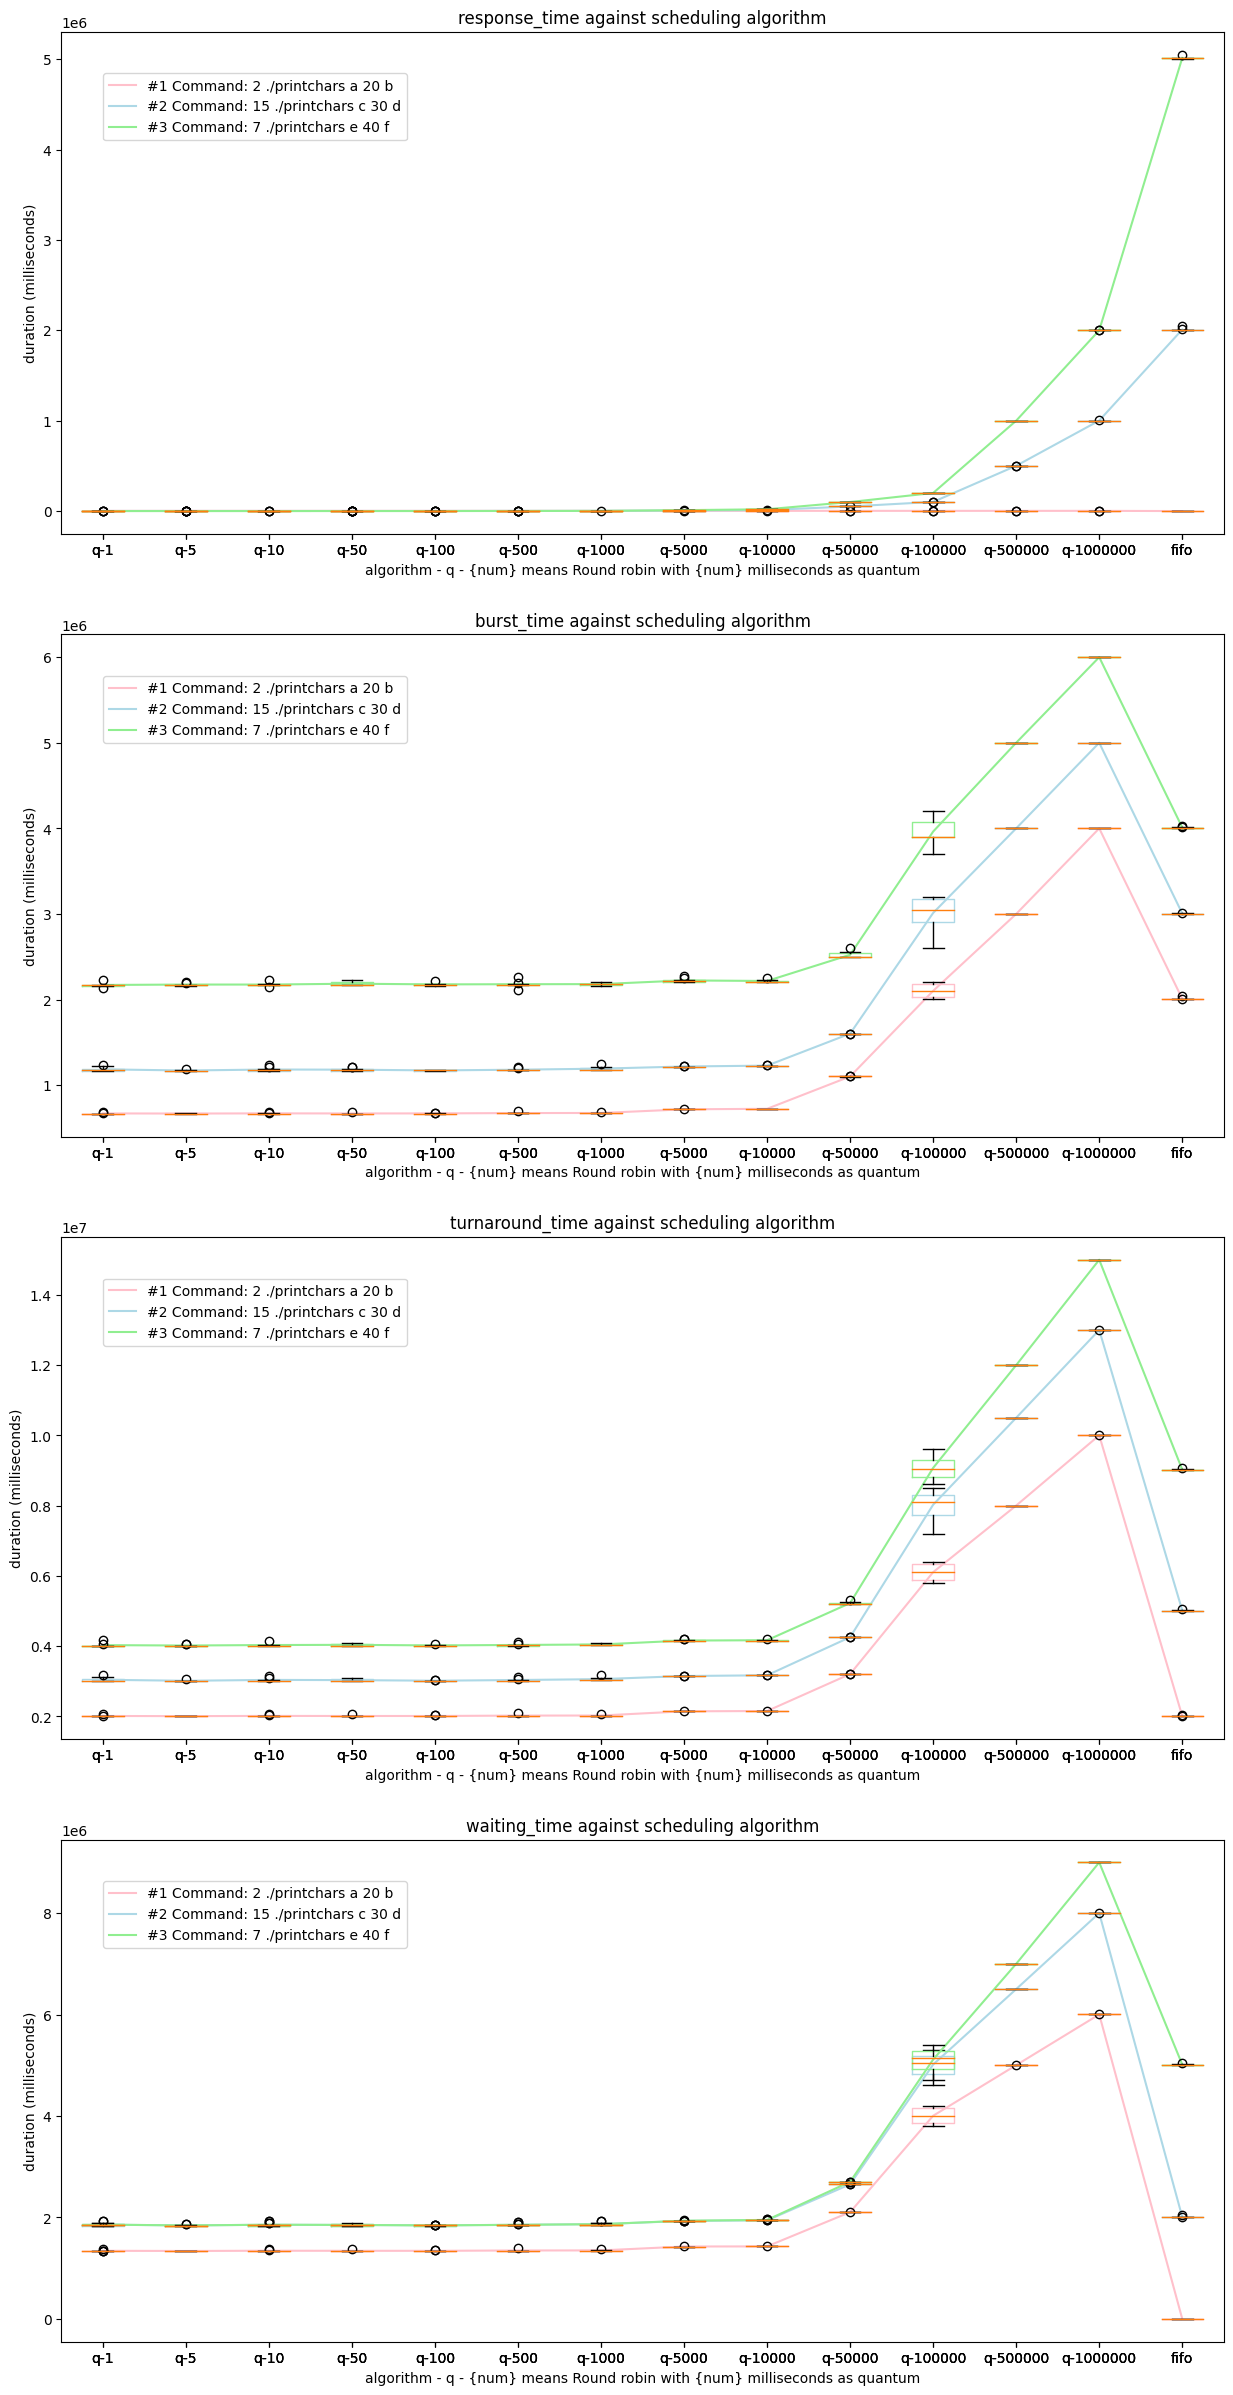

In [253]:
fig, axs = plt.subplots(4, 1, figsize=(15, 30))

colors = ["pink", "lightblue", "lightgreen"]

for m,metric in enumerate(["response_time", "burst_time", "turnaround_time", "waiting_time"]):
    for c, (command,color) in enumerate(zip(list(rr_results.keys()), colors)):
        axs[m].set_title(f"{metric} against scheduling algorithm")
        axs[m].set_xlabel("algorithm - q - {num} means Round robin with {num} milliseconds as quantum")
        axs[m].set_ylabel("duration (milliseconds)")
        rr_target = rr_results[command][metric]
        x = list(map(lambda quantum: f"q-{quantum}", rr_target.keys()))
        y = list(rr_target.values())
        
        x_box = x + ["fifo"]
        y_box = y + [fifo_results[command][metric]]
        
        x_plot = x
        x_plot = x_plot + ["fifo"]
        y_plot = np.append(np.array(y).mean(axis=1), fifo_results[command][metric].mean())

        axs[m].plot(x_plot, y_plot, color=color, label=f"#{c+1} {command}")
        axs[m].boxplot(y_box, labels=x_box, whis=1.5, meanline=True,boxprops=dict(color=color), positions=range(len(y_plot)))
        axs[m].legend(loc='upper left', ncol=1, borderaxespad=3)